In [21]:
import json
import pandas as pd
import numpy as np
import datetime
import helpers
import SessionSet
from importlib import reload

In [27]:
reload(helpers)
json_data = json.load(open('./city_search.json'))
helpers.preprocess_json_for_pandas(json_data)
df = pd.io.json.json_normalize(json_data)
df['time_of_day'] = pd.Series(df['unix_timestamp'] % helpers.SECONDS_PER_DAY)
df['session_date'] = df.apply(lambda row: datetime.datetime.utcfromtimestamp(row['unix_timestamp']), axis=1)
df['month'] = df.apply(lambda row: row['session_date'].month, axis=1)
df['year'] = df.apply(lambda row: row['session_date'].year, axis=1)
df.replace('','??', inplace=True)
df.head()


,cities,session_id,unix_timestamp,user._row,user.country,user.joining_date,user.user_id,time_of_day,session_date,month,year
0,"[New York NY, Newark NJ]",X061RFWB06K9V,1442503708,NaN,UK,2015-03-22,2024,55708,2015-09-17 15:28:28,9,2015
1,"[New York NY, Jersey City NJ, Philadelphia PA]",5AZ2X2A9BHH5U,1441353991,NaN,DE,2015-03-28,2853,29191,2015-09-04 08:06:31,9,2015
2,[San Antonio TX],SHTB4IYAX4PX6,1440843490,NaN,UK,2015-03-06,10958,37090,2015-08-29 10:18:10,8,2015
3,[Edmonton AB],JBRB8MZGTX3M4,1427268063,NaN,IT,2015-03-12,7693,26463,2015-03-25 07:21:03,3,2015
4,"[Phoenix AZ, Houston TX]",YJCMPURC2FL9C,1430559067,NaN,UK,2015-02-28,7506,34267,2015-05-02 09:31:07,5,2015


In [30]:
df['year'].describe()

count    20022.0
mean      2015.0
std          0.0
min       2015.0
25%       2015.0
50%       2015.0
75%       2015.0
max       2015.0
Name: year, dtype: float64

In [25]:
reload(SessionSet)
countries_sessions = {} 
time_summary_df = pd.DataFrame()
for country in set(df['user.country'].values):
    countries_sessions[country] = SessionSet.SessionSet(df.loc[df.loc[:,'user.country'] == country ,:], country)
    time_summary_df[country] = countries_sessions[country].get_time_metrics()
time_summary_df = time_summary_df.T

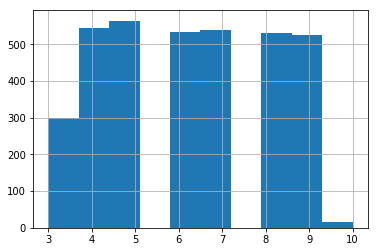

In [26]:
(countries_sessions['UK'].df['month_in_year']).hist()

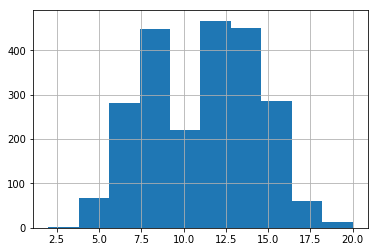

In [16]:
(countries_sessions['FR'].df['month_in_year']//helpers.SECONDS_PER_HOUR).hist()

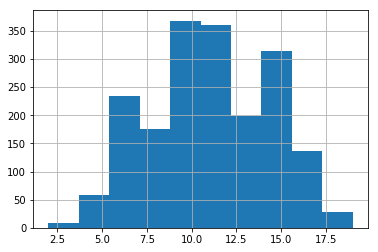

In [17]:
(countries_sessions['IT'].df['time_of_day']//helpers.SECONDS_PER_HOUR).hist()

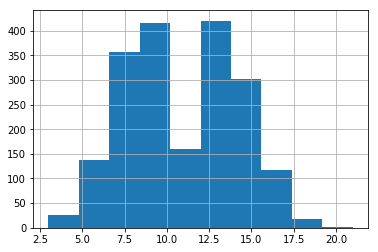

In [18]:
(countries_sessions['ES'].df['time_of_day']//helpers.SECONDS_PER_HOUR).hist()

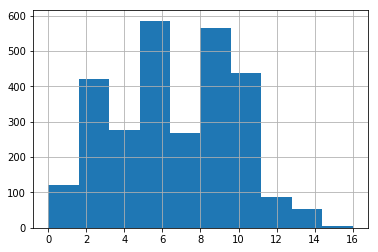

In [19]:
(countries_sessions['??'].df['time_of_day']//helpers.SECONDS_PER_HOUR).hist()

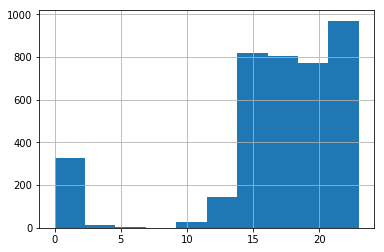

In [20]:
(countries_sessions['US'].df['time_of_day']//helpers.SECONDS_PER_HOUR).hist()